# Vehicle Detection Project for CarND

My achievement for the vehicle detection project. This notebook consists of following sections.

1. Extract features;
2. Train a classifier;
3. Generate sliding windows;
4. Find cars on test images;
5. Find cars on videos;
6. Discussions.

In [1]:
# modules
import cv2
import glob
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline

# 1. Extract Features

Extract features for SVM or Naive-Bayes classifiers. The extracted features include **hog features**, **binned spatial pixels** and **channel histograms**. 

The default settings of the following `FeatureExtractor` are listed as below:

| features      | parameters  |
| --------------- |:-----------:|
| color_space    |   YCrCb   |
| orient       |   9      |
| pix_per_cell   |  (8, 8)    |
| cell_per_block  |  (2, 2)    |
| hog_channel    |    ALL    |
| spatial_bin_size| (32, 32)   |
| hist_bins     |   32     |

>**PS**: If the classifier is a nerual network, this step will not be necessary.

In [902]:
class FeatureExtractor(object):
    
    def __init__(self, cfg=None):
        # Define color mode dict.
        self.cdict = {'HSV': cv2.COLOR_RGB2HSV,
                      'HLS': cv2.COLOR_RGB2HLS,
                      'LUV': cv2.COLOR_RGB2LUV,
                      'YUV': cv2.COLOR_RGB2YUV,
                      'YCrCb': cv2.COLOR_RGB2YCrCb}
        if cfg is None:
            self.color_space = 'YCrCb'
            self.orient = 9
            self.pix_per_cell = (8, 8)
            self.cell_per_block = (2, 2)
            self.hog_channel = 'ALL'
            self.spatial_size = (32, 32)
            self.hist_bins = 32
        else:
            self.color_space = cfg.color_space
            self.orient = cfg.orient
            self.pix_per_cell = cfg.pix_per_cell
            self.cell_per_block = cfg.cell_per_block
            self.hog_channel = cfg.hog_channel
            self.spatial_size = cfg.spatial_size
            self.hist_bins = cfg.hist_bins
    
    def extract_hog_feat(self, img):
        '''Extract hog features from a 2d image (one channel).'''
        features = hog(img, orientations=self.orient,
                       pixels_per_cell=self.pix_per_cell,
                       cells_per_block=self.cell_per_block)
        return features
    
    def vis_hog(self, img):
        '''Visualize the hog image.'''
        if self.color_space in self.cdict:
            feat_img = cv2.cvtColor(img, self.cdict[self.color_space])
        _, hog_img = hog(feat_img[:, :, 0], orientations=self.orient,
                         pixels_per_cell=self.pix_per_cell,
                         cells_per_block=self.cell_per_block,
                         visualise=True)
        return hog_img
    
    def extract_bin_spatial(self, img):
        '''Resize an image and flatten it.'''
        return cv2.resize(img, self.spatial_size).ravel()
    
    def extract_color_hist(self, img):
        '''Extract channel histograms from an image.'''
        ch1_hist = np.histogram(img[:, :, 0], bins=self.hist_bins)[0]
        ch2_hist = np.histogram(img[:, :, 1], bins=self.hist_bins)[0]
        ch3_hist = np.histogram(img[:, :, 2], bins=self.hist_bins)[0]
        return np.concatenate([ch1_hist, ch2_hist, ch3_hist])
    
    def extract_features(self, img, do_spatial=True,
                         do_hog=True, do_hist=True):
        '''Extract features of an image by relavent flags.'''
        # Convert color space.
        if self.color_space in self.cdict:
            feat_img = cv2.cvtColor(img, self.cdict[self.color_space])
        else: feat_img = img.copy()
        features = []
        # Extract features by flags.
        if do_spatial:
            spatial_features = self.extract_bin_spatial(feat_img)
            features.append(spatial_features)
        if do_hist:
            hist_features = self.extract_color_hist(feat_img)
            features.append(hist_features)
        if do_hog:
            if self.hog_channel == 'ALL':
                hog_features = []
                for ch in range(feat_img.shape[2]):
                    hog_features.extend(self.extract_hog_feat(
                        feat_img[:, :, ch]))
            else:
                hog_features = self.extract_hog_feat(
                    feat_img[:, :, self.hog_channel])
            features.append(hog_features)
        return np.concatenate(features)
    
    def extract_features_from_imgs(self, imgs, path=True, do_spatial=True,
                                   do_hog=True, do_hist=True):
        all_features = []
        for img in imgs:
            if path:
                img = plt.imread(img, format='RGB')
            features = self.extract_features(img,
                do_spatial=do_spatial, do_hog=do_hog, do_hist=do_hist)
            all_features.append(features)
        return all_features

Apply `FeatureExtractor` on some test images, visualize hog features.

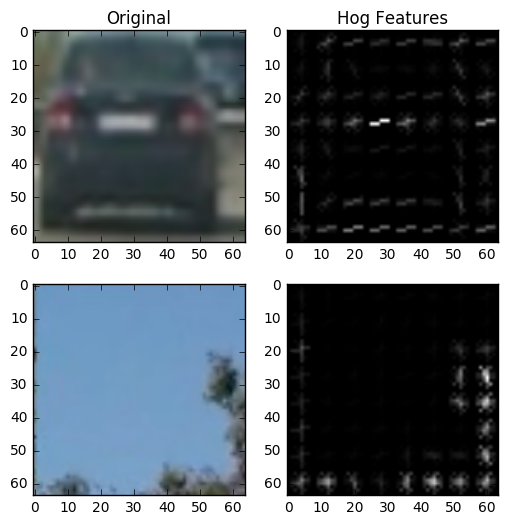

In [903]:
img1 = plt.imread('./train/vehicles/GTI_MiddleClose/image0000.png', format='RGB')
img2 = plt.imread('./train/non-vehicles/Extras/extra1.png', format='RGB')

fe = FeatureExtractor()
hog_img1 = fe.vis_hog(img1)
hog_img2 = fe.vis_hog(img2)
plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.imshow(img1)
plt.title('Original')
plt.subplot(222)
plt.imshow(hog_img1, 'gray')
plt.title('Hog Features')
plt.subplot(223)
plt.imshow(img2)
plt.subplot(224)
plt.imshow(hog_img2, 'gray')
plt.savefig('output_images/hog_features.png')
plt.show()

# 2. Train A Classifier

This section include two parts. The first part presents a feature classifier using machine learning techniques. The second part presents a simple convnet classifier.

## 2.1 Feature classifier

Classify an image from its features using a SVM (as default) classifier. The `VehicleFeatureClassifier` can also use a `NaiveBayes` or any other machine learning classification methods in `scikit-learn`. `VehicleFeatureClassifier` also provide `predict`, `save_fit` and `load_fit` methods for easy use. 

One caveat of such a feature classifier is that extracting features is computational expensive, it could significantly slow down the whole process.

In [1010]:
class VehicleFeatureClassifier(object):
    
    def __init__(self, clf=None):
        if clf is None:
            self.clf = LinearSVC()
        else: self.clf = clf
        self.fe = FeatureExtractor()
        self.scaler = None
        self.valid_acc = 0
    
    def load_features_and_labels(self, car_path, noncar_path):
        '''Load images and extract features, then make training dataset.'''
        car_feat = self.fe.extract_features_from_imgs(car_path)
        noncar_feat = self.fe.extract_features_from_imgs(noncar_path)
        features = np.vstack((car_feat, noncar_feat)).astype(np.float64)
        # Normalize feature data
        self.scaler = StandardScaler().fit(features)
        self.features = self.scaler.transform(features)
        self.labels = np.hstack([np.ones(len(car_feat)),
                                 np.zeros(len(noncar_feat))])
        
    def train_and_valid(self):
        '''
        Train loaded dataset using a scikit-learn classification method.
        The loaded dataset are splitted into train and valid parts.
        '''
        # Split dataset
        X_train, X_valid, y_train, y_valid = train_test_split(
            self.features, self.labels, test_size=0.2)
        self.clf.fit(X_train, y_train)
        self.valid_acc = self.clf.score(X_valid, y_valid)
        
    def predict(self, imgs):
        '''Predict images. Input should be a list of image arrays.'''
        features = self.fe.extract_features_from_imgs(imgs, path=False)
        features = self.scaler.transform(features)
        prediction = self.clf.predict(features)
        return prediction
    
    def save_fit(self, fname='saved_fit.p'):
        '''Save fitted classifier and scaler to a pickle file.'''
        saved_dict = {}
        saved_dict['clf'] = self.clf
        saved_dict['scaler'] = self.scaler
        with open(fname, 'wb') as f:
            pickle.dump(saved_dict, f)
        print('Fitted clf and scaler saved to {}.'.format(fname))
    
    def load_fit(self, fname='saved_fit.p'):
        '''Load'''
        with open(fname, 'rb') as f:
            saved_dict = pickle.load(f)
        self.clf = saved_dict['clf']
        self.scaler = saved_dict['scaler']
        print('Fitted clf and scaler loaded from {}.'.format(fname))

Train a `LinearSVC` Classifier. The final valid accuray is 99.35%, which is pretty good result. However, the input image features must be strictly similar as the training features to distinct a car, if, say, an image only present part of a car or the car is propotionally small, the classifier won't give a correct result.

In [905]:
car_path = glob.glob('./train/vehicles/*/*.png')
noncar_path = glob.glob('./train/non-vehicles/*/*.png')

clf = VehicleFeatureClassifier()
clf.load_features_and_labels(car_path, noncar_path)
clf.train_and_valid()
print('Final valid accuracy is {}'.format(clf.valid_acc))
clf.save_fit()

Final valid accuracy is 0.9935247747747747
Fitted clf and scaler saved to saved_fit.p.


In [906]:
clf = VehicleFeatureClassifier()
clf.load_fit()
img1 = plt.imread('./train/vehicles/GTI_MiddleClose/image0000.png', format='RGB')
img2 = plt.imread('./train/non-vehicles/Extras/extra1.png', format='RGB')
clf.predict([img1, img2])

Fitted clf and scaler loaded from saved_fit.p.


array([ 1.,  0.])

## 2.2 Convnet classifier

Classify an image directly using a simple convnet. My convnet consists of 3 `convolutional` layer and 2 `fully-connected` layer. Also, I embedded the normalization step into to network.

As compared to a SVM feature classifier, the convnet can also predict correctly even an image only present part of a car or the car is propotionally small.

In [915]:
from sklearn.utils import shuffle

from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Lambda
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical

assert K.image_dim_ordering() == 'tf', 'Image array should be in tf mode.'

def data_generator(all_paths, all_labels, batch_size=64):
    n_samples = len(all_paths)
    start = 0
    while True:
        end = start + batch_size
        batch_paths = all_paths[start:end]
        batch_x = np.array([plt.imread(path, format='RGB') for path in batch_paths])
        batch_y = all_labels[start:end]
        start += batch_size
        if start >= n_samples:
            start = 0
            all_paths, all_labels = shuffle(all_paths, all_labels)
        batch_x, batch_y = shuffle(batch_x, batch_y)
        yield batch_x, batch_y

def normalize(x):
    '''x should be a tensor'''
    x = K.cast(x, dtype='float32')
    normed = x / 255.0 - 0.5
    return normed

def convnet(features):
    '''features should be an keras Input layer.'''
    normed = Lambda(normalize, name='normed')(features)
    conv1 = Conv2D(16, 3, 3, border_mode='same', activation='relu', name='conv1')(normed)
    pool1 = MaxPooling2D((2, 2), name='pool1')(conv1)
    conv2 = Conv2D(16, 3, 3, border_mode='same', activation='relu', name='conv2')(pool1)
    pool2 = MaxPooling2D((2, 2), name='pool2')(conv2)
    conv3 = Conv2D(16, 3, 3, border_mode='same', activation='relu', name='conv3')(pool2)
    pool3 = MaxPooling2D((2, 2), name='pool3')(conv3)
    flatten = Flatten(name='flatten')(pool3)
    fc1 = Dense(256, activation='relu', name='fc1')(flatten)
    fc1 = Dropout(0.5, name='fc1_dropout')(fc1)
    fc2 = Dense(128, activation='relu', name='fc2')(fc1)
    fc2 = Dropout(0.5, name='fc2_dropout')(fc2)
    predictions = Dense(2, activation='softmax', name='output')(fc2)
    return predictions

class ConvNetClassifier(object):
    
    def __init__(self, config):
        self.config = config
        self.input_shape = (64, 64, 3)
        self._load_data()
        self._add_model()
    
    def _load_data(self):
        all_paths = list(self.config.car_path) + list(self.config.noncar_path)
        all_labels = np.concatenate((np.ones(len(self.config.car_path)),
                                     np.zeros(len(self.config.noncar_path))))
        all_labels = to_categorical(all_labels)
        train_paths, valid_paths, train_labels, valid_labels = train_test_split(
            all_paths, all_labels, test_size=0.2)
        self.train_datagen = data_generator(train_paths, train_labels,
                                            self.config.batch_size)
        self.valid_datagen = data_generator(valid_paths, valid_labels,
                                            self.config.batch_size)
        self.train_n_samples = len(train_paths)
        self.valid_n_samples = len(valid_paths)
    
    def _add_model(self):
        features = Input(shape=self.input_shape, name='features')
        predicts = convnet(features)
        self.model = Model(features, predicts)
        self.model.compile(optimizer=Adam(),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    
    def train(self, fine_tune=False):
        '''Train or fine_tune the model.'''
        weights_path = self.config.save_model_name+'.h5'
        if fine_tune and os.path.exists(weights_path):
            print('Loading {}'.format(weights_path))
            self.model.load_weights(weights_path)
        # callbacks
        save_best_model = ModelCheckpoint(weights_path,
                                          save_best_only=True,
                                          save_weights_only=True)
        callback_list = [save_best_model]
        # train ops
        self.model.fit_generator(self.train_datagen,
                                 samples_per_epoch=self.train_n_samples,
                                 nb_epoch=self.config.epoches,
                                 validation_data=self.valid_datagen,
                                 nb_val_samples=self.valid_n_samples,
                                 callbacks=callback_list)
        
    def predict(self, imgs):
        imgs = np.array(imgs).reshape((-1, 64, 64, 3))
        predicts = self.model.predict(imgs, batch_size=self.config.batch_size)
        return np.argmax(predicts, axis=1)
    
    def load_model(self, weights_path=None):
        if weights_path is None:
            weights_path = self.config.save_model_name+'.h5'
        print('Loading {}'.format(weights_path))
        self.model.load_weights(weights_path)
    
    def evaluate(self, X=None, y=None):
        self.model.compile(optimizer=Adam(),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
        if X is None or y is None:
            loss, acc = self.model.evaluate_generator(self.valid_datagen,
                                                      self.valid_n_samples)
        else:
            loss, acc = self.model.evaluate(X, y)
        return acc

The final valid accuray is 99.52%, which is better than SVM feature classifier.

In [967]:
class CNConfig:
    car_path = glob.glob('./train/vehicles/*/*.png')
    noncar_path = glob.glob('./train/non-vehicles/*/*.png')
    batch_size = 512
    epoches = 30
    save_model_name = 'convnet_model'

cncfg = CNConfig()
cnclf = ConvNetClassifier(cncfg)
# cnclf.train()
cnclf.load_model()
valid_acc = cnclf.evaluate()
print(valid_acc)

Loading convnet_model.h5
0.995213961279


In [919]:
img1 = plt.imread('./train/vehicles/GTI_MiddleClose/image0000.png', format='RGB')
img2 = plt.imread('./train/non-vehicles/Extras/extra1.png', format='RGB')
cnclf.predict([img1, img2])

array([1, 0])

# 3. Generate Sliding Windows

I implement two methods to generate sliding windows. One for the feature classifier, the other for the convnet.

- **windows for feature classifier**: Since such a classifier strictly limit the input image to be a car with proper fitted size, I generate the windows in a perspective way as the road.
- **windows for convnet classifier**: Three sliding windows in different yrange and size.

## 3.1 Windows for feature classifier

In [921]:
class WarpPerspective(object):

    def __init__(self, src=None, dst=None, img_size=(1280, 720)):
        self.img_size = img_size
        if src is None or dst is None:
            self.src = np.float32(
                [[(img_size[0] / 2) - 68, img_size[1] / 2 + 90],
                 [0, img_size[1]],
                 [img_size[0], img_size[1]],
                 [(img_size[0] / 2) + 62, img_size[1] / 2 + 90]])
            self.dst = np.float32(
                [[img_size[0] * 2/5, img_size[1] / 4],
                 [img_size[0] * 2/5, img_size[1]],
                 [img_size[0] * 3/5, img_size[1]],
                 [img_size[0] * 3/5, img_size[1] / 4]])
        else:
            self.src = np.float32(src)
            self.dst = np.float32(dst)
        # Calculate transform matrix and inverse matrix
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.M_inv = cv2.getPerspectiveTransform(self.dst, self.src)

    def warp(self, img):
        '''Warp an image from perspective view to bird view.'''
        assert (img.shape[1], img.shape[0]) == self.img_size, 'Invalid image shape.'
        return cv2.warpPerspective(img, self.M, self.img_size)

    def warp_inv(self, img):
        '''Warp inversely an image from bird view to perspective view.'''
        assert (img.shape[1], img.shape[0]) == self.img_size, 'Invalid image shape.'
        return cv2.warpPerspective(img, self.M_inv, self.img_size)


class SlidingWindows(object):
    
    def __init__(self, wp, imgsize=(1280, 720), sep=[25, 25]):
        self.wp = wp
        self.imgsize = imgsize
        self.sep = sep  # grid point separation
        self._make_grid_points()
        self._make_sliding_windows()
    
    def _make_grid_points(self):
        '''Generate grid points in a bird view.'''
        xsize, ysize = self.imgsize
        self._xsteps = int(xsize / self.sep[0]) + 1
        self._ysteps = int(ysize / self.sep[1])
        grid = np.mgrid[0:self._xsteps, 0:self._ysteps]
        self.grid_points = grid.T.reshape((-1, 2)) * self.sep
        # Transform the grid points in a perspective view.
        points_transformed = []
        for point in self.grid_points:
            coord = np.append(point, 1)
            transformed = np.dot(self.wp.M_inv, coord)
            point_transformed = (transformed[:2] / transformed[2]).astype(np.int)
            points_transformed.append(point_transformed)
        self.points_transformed = np.array(points_transformed)
        
    def _select_ysteps(self, ysteps):
        yseq = np.arange(ysteps - 1)
        yseq_r = yseq[::-1]  # np.flipud(yseq)
        n = np.int(np.sqrt(4 * ysteps + 0.25) + 0.5)
        idx_list = []
        for i in range(n-1):
            tmp = np.int(i * (i+1) / 4)
            idx_list.append(tmp)
        idx_list = np.unique(idx_list)
        return np.unique(np.append(yseq_r[idx_list], 0)[::-1])
    
    def _make_sliding_windows(self):
        window_list = []
        xseq = range(self._xsteps)
        yseq = self._select_ysteps(self._ysteps)
        for yc in yseq:
            xl = self.points_transformed[yc*self._xsteps][0]
            xr = self.points_transformed[(yc+1)*self._xsteps-1][0]
            width = int( (50/self.sep[0]) * (xr-xl) / (self._xsteps-1) )
            for xc in xseq:
                pos = yc*self._xsteps + xc
                point = self.points_transformed[pos]
                lu = point - np.array([0.5*width, 1.5*width], np.int).tolist()
                rd = point + np.array([1.5*width, 0.5*width], np.int).tolist()
                if 0 < lu[0] < self.imgsize[0] and rd[1] < self.imgsize[1]:
                    window_list.append((tuple(lu), tuple(rd)))
        self.windows = window_list

## 3.2 Windows for convnet classifier

In [868]:
def slide_window(imgsize=(1280, 720), xrange=[None, None], yrange=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if xrange[0] == None:
        xrange[0] = 0
    if xrange[1] == None:
        xrange[1] = imgsize[0]
    if yrange[0] == None:
        yrange[0] = 0
    if yrange[1] == None:
        yrange[1] = imgsize[1] 
    xspan = xrange[1] - xrange[0]
    yspan = yrange[1] - yrange[0]
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer) / nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer) / ny_pix_per_step) 
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs * nx_pix_per_step + xrange[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + yrange[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

Visualize two kinds of sliding windows. I generated 435 windows for a SVM feature classifier, and 1045 for a convnet classifier.

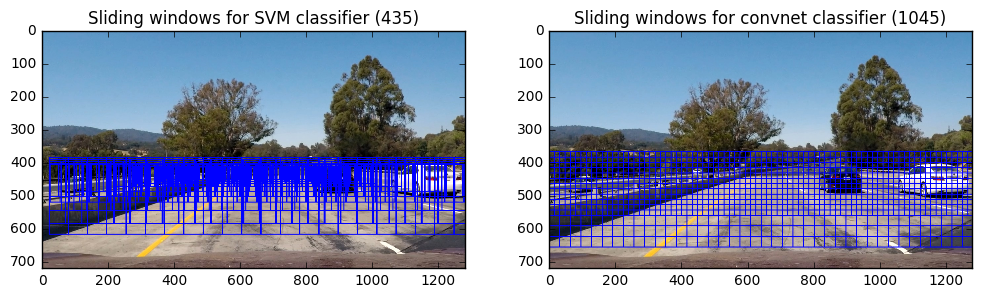

In [1009]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imgcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imgcopy, bbox[0], bbox[1], color, thick)
    return imgcopy

def draw_points(img, points, color=(255, 0, 0), thick=6):
    imgcopy = np.copy(img)
    for point in points:
        point = tuple(point)
        cv2.line(imgcopy, point, point, color, thick)
    return imgcopy

# Generate windows for feature classifier
wp = WarpPerspective()
sw = SlidingWindows(wp)
windows_v1 = sw.windows


# Generate windows for convnet classifier
windows_v2_0 = slide_window(yrange=[368, 464], xy_overlap=(0.5, 0.5), xy_window=(32, 32))
windows_v2_1 = slide_window(yrange=[400, 560], xy_overlap=(0.75, 0.75), xy_window=(64, 64))
windows_v2_2 = slide_window(yrange=[464, 656], xy_overlap=(0.75, 0.75), xy_window=(128, 128))
windows_v2 = windows_v2_0 + windows_v2_1 + windows_v2_2

# Visualize sliding window proposals

img = plt.imread('test_images/test1.jpg')

plt.figure(figsize=(12, 4))
plt.subplot(121)
img_with_windows = draw_boxes(img, windows_v1, thick=2)
plt.imshow(img_with_windows)
plt.title('Sliding windows for SVM classifier ({})'.format(len(windows_v1)))
img_with_windows_v2 = draw_boxes(img, windows_v2, thick=2)
plt.subplot(122)
plt.imshow(img_with_windows_v2)
plt.title('Sliding windows for convnet classifier ({})'.format(len(windows_v2)))
plt.savefig('output_images/slide_windows.png')
plt.show()

# 4. Find Cars (for Image)

I implemented a `VehicleFinder` for image. The `VehicleFinder4Image` use a heatmap to reduce false positive results. As for the convnet classifier, the heatmap threshold is 4. One thing to note is that, I smoothed the heatmap for a more smooth car bbox result.

In [998]:
class VehicleFinder4Image(object):
    
    def __init__(self, windows, clf):
        self.windows = windows
        self.clf = clf
    
    def search_windows(self, img):
        hot_windows = []
        imgs = []
        for window in self.windows:
            (x1, y1), (x2, y2) = window
            if (x2 - x1 != 64) and (y2 - y1 != 64):
                img_win = cv2.resize(img[y1:y2, x1:x2], (64, 64))
            else: img_win = img[y1:y2, x1:x2]
            imgs.append(img_win)
        predictions = self.clf.predict(imgs)
        for i, window in enumerate(self.windows):
            if predictions[i] == 1:
                hot_windows.append(window)
        return hot_windows
    
    def add_heat(self, heatmap, hot_windows):
        for window in hot_windows:
            (x1, y1), (x2, y2) = window
            heatmap[y1:y2, x1:x2] += 1
        return heatmap
    
    def heat_thresh(self, heatmap, thresh):
        heatmap = cv2.resize(heatmap, (80, 45))
        heatmap = cv2.resize(heatmap, (1280, 720))
        heatmap[heatmap <= thresh] = 0
        return heatmap
    
    def detect_vehicles_bboxes(self, heatmap):
        labels = label(heatmap)
        bboxes = []
        for idx in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == idx).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)),
                    (np.max(nonzerox), np.max(nonzeroy)))
            bboxes.append(bbox)
        return bboxes
    
    def apply(self, img):
        hot_windows = self.search_windows(img)
        heatmap = np.zeros_like(img[:,:,0], dtype=np.float32)
        heatmap = self.add_heat(heatmap, hot_windows)
        heatmap = self.heat_thresh(heatmap, 4)
        vehicle_bboxes = self.detect_vehicles_bboxes(heatmap)
        img_detected = draw_boxes(img, vehicle_bboxes)
        return img_detected

For the sake of speed, I use the convnet as well as the windows for convnet. The convnet is 16 times faster than the feature classifier.

Below is the result of test images, each with a heatmap. The result is just perfect, with accurate bounding boxes and no false positive detections.

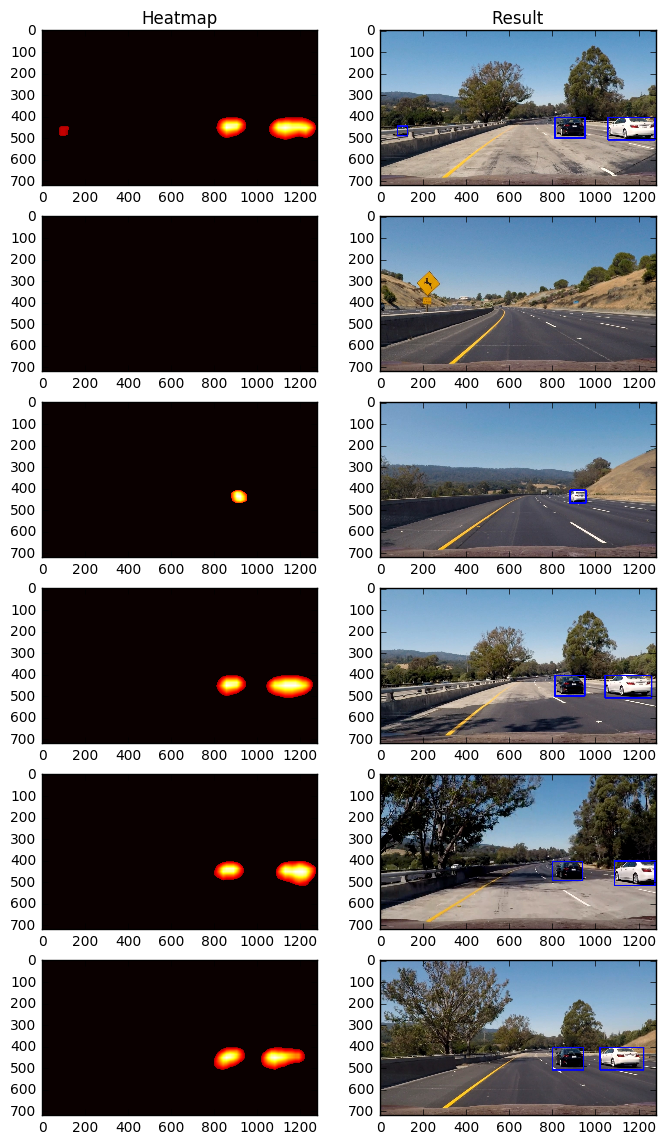

In [999]:
cf = VehicleFinder4Image(windows_v2, cnclf)
# cf = VehicleFinder4Image(windows_v1, clf)

plt.subplots(6, 2, figsize=(8, 14))

for i in range(6):
    img = plt.imread('test_images/test{}.jpg'.format(i+1), format='RGB')
    hot_windows = cf.search_windows(img)
    heatmap = np.zeros_like(img[:,:,0], dtype=np.float32)
    heatmap = cf.add_heat(heatmap, hot_windows)
    heatmap = cf.heat_thresh(heatmap, 4)
    result = cf.apply(img)
    plt.subplot(6, 2, 2*i+1)
    plt.imshow(heatmap, 'hot')
    if i == 0: plt.title('Heatmap')
    plt.subplot(6, 2, 2*i+2)
    plt.imshow(result)
    if i == 0: plt.title('Result')
plt.savefig('output_images/test_images_result.png')
plt.show()

Try `VehicleFinder4Image` on `test_video.mp4`. The processing speed is 8 frames per second. The result is OK, but the bounding boxes seems not perfectly stable from frame to frame. I will handle this problem in the next section.

In [1000]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

cf = VehicleFinder4Image(windows_v2, cnclf)
video_out = 'test_video_out_0.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(cf.apply)
%time white_clip.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video test_video_out_0.mp4
[MoviePy] Writing video test_video_out_0.mp4


 97%|█████████▋| 38/39 [00:04<00:00,  9.43it/s]      | 1/39 [00:00<00:03,  9.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_0.mp4 

CPU times: user 4.36 s, sys: 308 ms, total: 4.67 s
Wall time: 5.32 s


In [1001]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out))

# 5. Find Cars (for Video)

The `VehicleFinder4Video` inherit from `VehicleFinder4Image` with just one difference: I averaged last `n_recs` (default as 5) heatmaps and then apply a threshold of 4.5. The result now become much stable.

In [1002]:
from collections import deque

class VehicleFinder4Video(VehicleFinder4Image):
    
    def __init__(self, windows, clf, n_recs=5):
        super(VehicleFinder4Video, self).__init__(windows, clf)
        self.n_recs = n_recs
        self.heatmaps = deque(maxlen=self.n_recs)
    
    def apply(self, img):
        hot_windows = self.search_windows(img)
        heatmap = np.zeros_like(img[:,:,0], dtype=np.float32)
        heatmap = self.add_heat(heatmap, hot_windows)
        self.heatmaps.append(heatmap)
        heatmap = np.mean(self.heatmaps, axis=0)
        heatmap = self.heat_thresh(heatmap, 4)
        vehicle_bboxes = self.detect_vehicles_bboxes(heatmap)
        img_detected = draw_boxes(img, vehicle_bboxes)
        return img_detected

Apply `VehicleFinder4Video` on `test_video.mp4`. The result is no more words than perfect!

In [1003]:
cf = VehicleFinder4Video(windows_v2, cnclf)
video_out = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(cf.apply)
%time white_clip.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:04<00:00,  8.52it/s]      | 1/39 [00:00<00:05,  7.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 4.8 s, sys: 228 ms, total: 5.03 s
Wall time: 5.65 s


In [1004]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out))

Apply `VehicleFinder4Video` on `project_video.mp4`. The result is great!

In [1005]:
cf = VehicleFinder4Video(windows_v2, cnclf)
video_out = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(cf.apply)
%time white_clip.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [02:31<00:00,  7.68it/s]    | 1/1261 [00:00<02:06,  9.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 2min 31s, sys: 4.62 s, total: 2min 36s
Wall time: 2min 31s


In [1006]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out))

# 6. Discussions

I implemented 2 kinds of classifier, one using machine learning techniques to classify image features, the other using a convnet to classify image directly. 

One caveat of the feature classifier is that extracting features of about more than 400 windows consumes too much time. Another problem is that such a classifier can not work well if an input image is a part of a vehicle or the car in the image is propotional too small. So I prefer a convnet classifier. And what's more, the convnet classifier is much faster using GPU. I generated more than 1000 windows for it. However, if I want an even better result, say more accurate bounding boxes and even detecting far away small vehicles, I need more small window proposals, which would significantly slow down detection speed.

My future plan is to design an end-to-end object detection network, such as YOLO, SSD. I am still working on it.